In [33]:
# 載入所需套件
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

# 讀取檔案
HomeCredit_train = pd.read_csv(f_app_train)
HomeCredit_test = pd.read_csv(f_app_test)

# 種類 2 種以下的類別型欄位轉標籤編碼 (Label Encoding)
le = LabelEncoder()
le_count = 0

# 檢查每一個 column
for column in HomeCredit_train:
    if HomeCredit_train[column].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(HomeCredit_train[column].unique())) <= 2:
            # 就做 Label Encoder
            le.fit(HomeCredit_train[column])
            HomeCredit_train[column] = le.transform(HomeCredit_train[column])
            HomeCredit_test[column] = le.transform(HomeCredit_test[column])
            
            # 紀錄有多少個 columns 被標籤編碼過
            le_count += 1
            
# 標籤編碼 (2種類別) 欄位轉 One Hot Encoding            
HomeCredit_train = pd.get_dummies(HomeCredit_train)
HomeCredit_test = pd.get_dummies(HomeCredit_test)  

# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
HomeCredit_train['DAYS_EMPLOYED_ANOM'] = HomeCredit_train["DAYS_EMPLOYED"] == 365243
HomeCredit_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
HomeCredit_test['DAYS_EMPLOYED_ANOM'] = HomeCredit_test["DAYS_EMPLOYED"] == 365243
HomeCredit_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
HomeCredit_train['DAYS_BIRTH'] = abs(HomeCredit_train['DAYS_BIRTH'])
HomeCredit_test['DAYS_BIRTH'] = abs(HomeCredit_test['DAYS_BIRTH'])

train_labels = HomeCredit_train['TARGET']

# 調整欄位數, 移除出現在 training data 而沒有出現 testing data 中的欄位
HomeCredit_train, HomeCredit_test = HomeCredit_train.align(HomeCredit_test, join = 'inner', axis = 1)

In [34]:
# 特徵欄位清單
train = HomeCredit_train
features = list(train.columns)

# 複製 test 資料
test = HomeCredit_test.copy()

# 填補器 : 設定缺失值補中位數
imputer = SimpleImputer(strategy = 'median')

# 縮放器 : 設定特徵縮放到 0~1 區間
scaler = MinMaxScaler(feature_range = (0, 1))

# 填補器載入個欄中位數
imputer.fit(train)

# 將中位數回填 train, test 資料中的空缺值
train = imputer.transform(train)
test = imputer.transform(HomeCredit_test)

# 縮放器載入 train 的上下限, 對 train, test 進行縮放轉換
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [35]:
# Fit the model
# 模型 fit 好以後，就可以用來預測 testing data 中的客戶違約遲繳貸款的機率咯! 
# (記得要用 predict_proba 才會輸出機率)

# 設定模型與模型參數
log_reg = LogisticRegression(C = 0.0001)

# 使用 Train 資料訓練模型
print(log_reg.fit(train, train_labels))

# 用模型預測結果
# 請注意羅吉斯迴歸是分類預測 (會輸出 0 的機率, 與 1 的機率), 而我們只需要留下 1 的機率這排
log_reg_pred = log_reg.predict_proba(test)[:, 1]

# 計算提交結果
submit = HomeCredit_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,SK_ID_CURR,TARGET
0,100001,0.065383
1,100005,0.117354
2,100013,0.067974
3,100028,0.070889
4,100038,0.117988


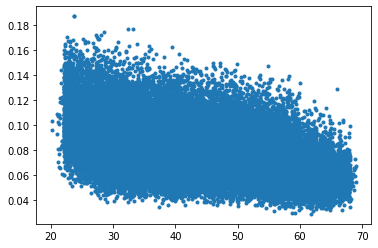

In [36]:
plt.plot(HomeCredit_test['DAYS_BIRTH']/(365),submit['TARGET'],'.')
plt.show()